In [1]:
#Set the path to the hawkes library
import os 
import sys

module_dir = os.path.join("..", 'build') # path to the hawkes library and sometimes it's 'build\Debug' or 'build\Release' for windows    
sys.path.insert(0, module_dir)

In [2]:
import hawkes
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, optimizers
import matplotlib.colors as mcolors
import time
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
tf.config.run_functions_eagerly(True)

2025-01-26 14:18:09.392627: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-26 14:18:09.400969: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-26 14:18:09.434274: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737901089.482616   10752 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737901089.499068   10752 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-26 14:18:09.540571: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# SRM Model

In [3]:
class SRMModelExpPoisson():
    def __init__(self, dimension, listOfAlphas, meanJumps, sigmaJumps, nbThreads, mu, alpha, beta, T):
      self.d = dimension
      self.baseline = mu
      self.inhomo = alpha
      self.beta = beta
      self.horizon = T
      self.nbThreads = nbThreads
      self.alpha = listOfAlphas
      self.meanJ = meanJumps
      self.sigmaJ = sigmaJumps


    def simulateRiskFactors(self, nbSimul):
      hawkes_samples =  np.array(hawkes.SimulateHawkes(nbSimul, self.nbThreads, self.baseline, self.inhomo, self.beta, self.horizon, False)[0])
      #normal_samples = np.random.normal(loc=self.meanJ, scale=self.sigmaJ, size=[nbSimul, self.d])*hawkes_samples
      gamma_samples = np.random.gamma(shape = self.meanJ, scale=self.sigmaJ, size = [nbSimul, self.d])*hawkes_samples
      return gamma_samples.astype(np.float32)
    
    def U(self, X, Y):
        return tf.reduce_mean(tf.math.reduce_sum(tf.maximum(X - Y,0), axis = 1) - 0.5*tf.math.reduce_sum(tf.maximum(Y - X,0), axis = 1))


# Neural networks Config

In [4]:
#Let's define the Neural network
################################################################################

class Net(tf.keras.Model):
    def __init__( self, ndimOut, nbNeurons, activation= tf.nn.tanh):
        super().__init__()
        self.nbNeurons = nbNeurons
        self.name_ = "FeedForward"
        self.ndimOut= ndimOut
        self.ListOfDense =  [layers.Dense( nbNeurons[i],activation= activation, kernel_initializer= tf.keras.initializers.GlorotNormal())  for i in range(len(nbNeurons)) ]+[layers.Dense(ndimOut, activation= None, kernel_initializer= tf.keras.initializers.GlorotNormal())]


    def call(self,inputs):
        x = inputs
        for layer in self.ListOfDense:
            x = layer(x)
        return x

class NetDeterministic(tf.keras.Model):
    def __init__( self, ndimOut):
        super().__init__()
        self.name_ = "TrainableVariables"
        self.ndimOut= ndimOut
        self.add_weight(name = 'Variables', shape = (self.ndimOut,), initializer = tf.keras.initializers.GlorotNormal(), trainable = True)


    def call(self,inputs):
        return tf.broadcast_to(self.Variables, [inputs.shape[0], self.ndimOut])

class DualVariables(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.name_ = 'DualVariables'
        self.lam = self.add_weight(name='lam', shape=[], initializer=tf.keras.initializers.GlorotNormal(), trainable=True, dtype=tf.float32)
        self.mu = self.add_weight(name='mu', shape=[], initializer=tf.keras.initializers.GlorotNormal(), trainable=True, dtype=tf.float32)

# SRM Solver

In [9]:
#Let's train the Neural Network
################################################################################

class SRMSolver():
  def __init__(self, SRMModel, Network, DualVariables, learningRate):
    self.SRM = SRMModel
    self.Net = Network
    self.DV = DualVariables
    self.lRate = learningRate

  def train(self,  batchSize,  batchSizeVal, num_epoch, num_epochExt):
    @tf.function
    def optimizePrimal(nbSimul):
      X = self.SRM.simulateRiskFactors(nbSimul)
      Xnorm = X
      #Xnorm =  (X - tf.reduce_mean(X, axis=0)) / tf.math.reduce_std(X, axis=0)
      Gamma = tf.math.abs(tf.reduce_sum(self.Net(Xnorm), axis = 1)  - tf.reduce_mean(tf.reduce_sum(self.Net(Xnorm), axis = 1)))
      return tf.reduce_mean(tf.reduce_sum(self.Net(Xnorm), axis = 1)) + (self.DV.mu**2)*tf.reduce_mean(Gamma) + (self.DV.lam**2)*(self.SRM.U(X, self.Net(Xnorm)))

    # train to optimize control
    @tf.function
    def trainOpt(nbSimul, optimizer):
        with tf.GradientTape(persistent=True) as tape:
            objFuncPrimal = optimizePrimal(nbSimul)
            objFuncDual = -optimizePrimal(nbSimul)
        gradientsPrimal = tape.gradient(objFuncPrimal, self.Net.trainable_variables)
        gradientsDual = tape.gradient(objFuncDual, self.DV.trainable_variables)
        optimizer.apply_gradients(zip(gradientsPrimal + gradientsDual\
                                      , self.Net.trainable_variables + \
                                        self.DV.trainable_variables))

        del tape
        return objFuncPrimal

    # set the ADAM optimizer
    optimizer= optimizers.Adam(learning_rate = self.lRate)
    listRho = []
    for iout in range(num_epochExt):
      start_time = time.time()
      for epoch in range(num_epoch):
          # un pas de gradient stochastique
          trainOpt(batchSize, optimizer)
      end_time = time.time()
      rtime = end_time-start_time
      objError = optimizePrimal(batchSizeVal)
      print('estimated SRM' , objError.numpy(), 'dv', self.DV.lam.numpy(), " took %5.3f s" % rtime, 'epoch', iout)
      listRho.append(objError)
    return listRho

# Main

In [10]:
#Parameters
################################################################################
#Deep learning model
nbNeurons = 64
nbLayer = 2
layerSize = nbNeurons*np.ones((nbLayer,), dtype=np.int32)
num_epochExt = 150
num_epoch = 1000
batchSize = 100
lRate = 3e-5
activation = tf.nn.tanh

#SRM model
utility = 'relu'
riskFactorDistribution = 'Hawkes'

if utility == 'relu' and riskFactorDistribution == 'Hawkes':
    d = 10
    listalpha = np.array([1.11, 1.20, 1.36, 1.89, 1.94, 2.5, 4.0, 1.9, 1.1, 1.2]).astype(np.float32)
    meanJumps = np.ones(d)
    volJumps = 2*np.ones(d)
    # Test the simulate_hawkes function
    mu = np.array([2.0, 1.5, 0.01, 0.1, 0.8, 2.0, 0.3, 0.2, 0.5, 0.01])
    alpha = np.array([
        [0.5, 0.1, 3.0, 2.0, 0.4, 2.4, 0.1, 1.5, 0.1, 0.1],
        [0.2, 0.6, 3.0, 0.1, 0.2, 0.1, 0.7, 1.2, 0.1, 0.5],
        [3.5, 3.0, 4.0, 3.0, 0.1, 2.0, 0.2, 1.3, 0.1, 2.0],
        [0.1, 0.2, 0.2, 0.5, 0.1, 0.1, 0.1, 0.2, 0.1, 2.0],
        [0.3, 0.1, 1.1, 1.0, 0.6, 0.8, 0.1, 1.5, 0.1, 0.1],
        [0.1, 0.2, 0.1, 0.1, 0.1, 0.4, 0.2, 0.1, 0.1, 3.],
        [0.1, 0.2, 2.0, 3.0, 0.5, 0.1, 0.3, 0.1, 0.5, 0.1],
        [3.0, 0.1, 0.3, 0.2, 0.4, 0.1, 0.1, 0.3, 0.6, 0.1],
        [0.1, 0.1, 0.1, 2.3, 0.1, 0.1, 3.0, 0.1, 0.1, 0.1],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0]
    ])
    beta = 2*np.array([
        [5.0, 5.0, 5.0, 7.5, 4.0, 5.0, 0.5, 5.0, 5.0, 5.0],
        [4.5, 6.0, 7.5, 4.0, 5.0, 5.5, 5.0, 3.0, 5.0, 5.0],
        [5.0, 5.5, 6.0, 4.5, 6.5, 7.0, 4.0, 2.0, 5.0, 5.0],
        [1.0, 5.0, 2.5, 3.0, 4.5, 1.5, 1.0, 3.0, 5.0, 5.0],
        [0.5, 5.0, 2.0, 1.5, 5.0, 1.0, 1.5, 2.0, 5.0, 5.0],
        [4.5, 7.0, 7.5, 3.0, 6.0, 5.0, 6.5, 0.5, 5.0, 5.0],
        [4.0, 6.5, 8.0, 3.5, 5.0, 6.0, 5.5, 0.5, 5.0, 5.0],
        [4.5, 6.0, 8.5, 4.0, 5.5, 6.5, 6.0, 0.5, 5.0, 5.0],
        [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0],
        [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
    ])
    T = 1.0
    nbThreads = 10

In [11]:
#SOLVE
################################################################################
SRM = []
for _ in range(1):
    modelSRM = SRMModelExpPoisson(d, listalpha, meanJumps, volJumps, nbThreads, mu, alpha, beta, T)
    NN = Net(d, layerSize, activation)
    DualVar = DualVariables()
    solver = SRMSolver(modelSRM, NN, DualVar, lRate)
    listRho = solver.train(batchSize, 10*batchSize, num_epoch, num_epochExt)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(listRho, label = 'estimated' + r' $\rho_X$')
    #ax.plot(theoretical_value*np.ones(num_epochExt), label = 'explicit formula', linestyle = 'dashed')
    ax.set_title('Convergence of the primal algorithm')
    ax.set_xlabel('epochs')
    ax.legend()
    ax.grid(True)
    # Create the inset plot for zooming into the last few iterations
    zoom_start = 140  # Start zooming in from this epoch
    axins = zoomed_inset_axes(ax, zoom=2, loc='right')
    axins.plot(listRho, color='blue')
    axins.set_xlim(zoom_start, 150)  # Limit the x-axis to the last few iterations
    axins.set_ylim(min(listRho[zoom_start:]), max(listRho[zoom_start:]))
    axins.grid(True)

    # Mark the region of the main plot that is zoomed in
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

    plt.show()
    SRM.append(listRho[-1])

Simulation 1: 3 1 0 0 2 4 2 1 2 0 
Simulation 2: 1 2 0 0 3 2 0 2 1 0 
Simulation 3: 3 2 5 1 3 5 2 1 3 0 
Simulation 4: 4 0 3 1 2 1 3 1 3 0 
Simulation 5: 7 1 3 1 5 1 2 3 0 0 
Simulation 6: 6 4 9 2 3 3 4 5 4 0 
Simulation 7: 2 6 1 0 1 5 2 0 0 0 
Simulation 8: 2 4 5 0 1 1 2 0 1 0 
Simulation 9: 1 1 1 0 2 2 0 1 2 0 
Simulation 10: 10 4 5 0 8 3 1 2 2 0 
Simulation 11: 4 2 7 0 3 1 5 2 3 0 
Simulation 12: 1 0 2 1 1 3 0 2 0 0 
Simulation 13: 4 3 3 1 3 4 0 1 0 0 
Simulation 14: 5 5 4 2 2 1 2 2 2 0 
Simulation 15: 2 4 2 0 1 5 1 0 1 0 
Simulation 16: 7 6 10 2 3 6 3 3 3 0 
Simulation 17: 11 5 7 1 9 0 1 6 1 0 
Simulation 18: 2 2 0 0 0 0 1 3 2 0 
Simulation 19: 5 11 9 1 5 5 1 5 1 0 
Simulation 20: 4 1 1 0 3 2 0 0 1 0 
Simulation 21: 2 2 2 0 1 1 0 2 1 0 
Simulation 22: 11 3 7 1 2 1 4 5 2 1 
Simulation 23: 6 7 12 1 2 3 1 2 3 0 
Simulation 24: 13 7 11 1 9 2 4 4 1 0 
Simulation 25: 3 2 1 1 3 7 0 1 1 0 
Simulation 26: 5 2 5 0 1 1 1 2 0 0 
Simulation 27: 6 3 4 0 6 1 1 5 1 0 
Simulation 28: 3 6 6 0 6 2 3 

KeyboardInterrupt: 

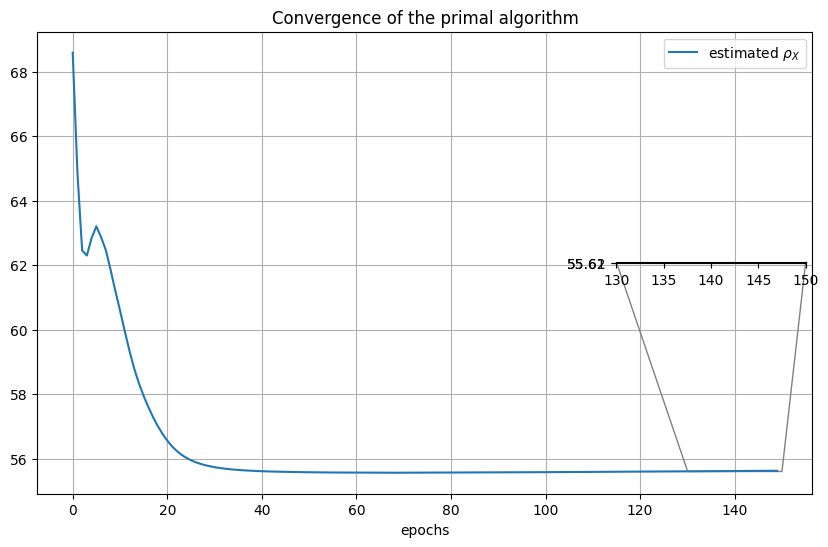

In [83]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(listRho, label = 'estimated' + r' $\rho_X$')
#ax.plot(theoretical_value*np.ones(num_epochExt), label = 'explicit formula', linestyle = 'dashed')
ax.set_title('Convergence of the primal algorithm')
ax.set_xlabel('epochs')
ax.legend()
ax.grid(True)
# Create the inset plot for zooming into the last few iterations
zoom_start = 130  # Start zooming in from this epoch
axins = zoomed_inset_axes(ax, zoom=2, loc='right')
axins.plot(listRho, color='blue')
axins.set_xlim(zoom_start, 150)  # Limit the x-axis to the last few iterations
axins.set_ylim(min(listRho[zoom_start:]), max(listRho[zoom_start:]))
axins.grid(True)

# Mark the region of the main plot that is zoomed in
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

plt.show()